In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import tools._torch_tools as tt
import models.loss as lo
from models.extrapolation import Model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is", device)

data_folder = "dataset_extrapolation/"

Device is cpu


In [5]:
X_train, y_train = mt.loadData("",train=True,typeF='float16')

Loading X_train.npy
Loading y_train.npy


In [2]:
X_val, y_val = mt.loadData(data_folder,val=True,typeF='float16')

Loading datasets/dataset_extrapolation/X_val.npy
Loading datasets/dataset_extrapolation/y_val.npy


In [2]:
X_test, y_test = mt.loadData(data_folder,test=True,typeF='float16')

Loading datasets/dataset_extrapolation/X_test.npy
Loading datasets/dataset_extrapolation/y_test.npy


In [3]:
class Training(tt.Training):
    def __init__(self,*args,**kwargs):
        super(Training,self).__init__(*args,**kwargs)
        
    def getBatch(self, offset, batch_size, val=False):
        input,target = super(Training,self).getBatch(offset, batch_size, val=val)
        target = target[:,:1,:,:]
        
        return input, target

### Training with the L1 loss

In [6]:
model = Model()
training = Training(model,device,X_train, y_train, X_val, y_val, loss_function=nn.L1Loss())

In [ ]:
try:
    training.fit(32,40,val=True)
except KeyboardInterrupt:
    print("\n\nFinished training.")

In [ ]:
training.save("l1.pth")

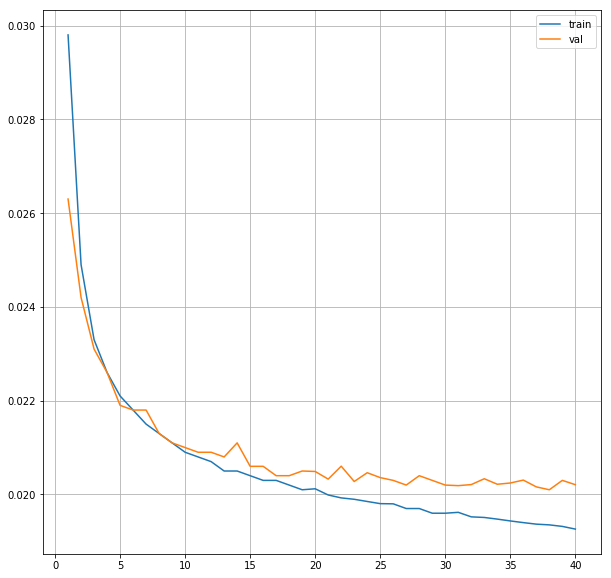

In [9]:
tt.plotHistory(training.history,save="history.png",size=(5,4))
tt.toCSV("history.csv",training.history)

### Training with the perceptual loss

In [8]:
model = Model()
model.load_state_dict(torch.load("l1.pth",map_location=device))
loss = lo.CombinedLoss(-18,0.00001)
training = Training(model,device,X_train, y_train, X_val, y_val, loss_function=loss)

In [15]:
try:
    training.fit(32, 35,val=True)
except KeyboardInterrupt:
    print("\n\nFinished training.")



====== TRAINING ======
===> Epoch[26](2112/2112): Loss: 0.0308	ETA 0:00:00	Epoch Loss: 0.0345
Epoch[26] finished in 0:03:10 with loss 0.03445934493069989
Validating on 16896 samples.
===> Validating (528/528):	ETA 0:00:00	Validation Loss: 0.0359
Validation loss = 0.0359

----------------------------

===> Epoch[27](2112/2112): Loss: 0.0311	ETA 0:00:00	Epoch Loss: 0.0344
Epoch[27] finished in 0:03:10 with loss 0.03444547412624216
Validating on 16896 samples.
===> Validating (528/528):	ETA 0:00:00	Validation Loss: 0.0360
Validation loss = 0.0360

----------------------------

===> Epoch[28](2112/2112): Loss: 0.0308	ETA 0:00:00	Epoch Loss: 0.0344
Epoch[28] finished in 0:03:09 with loss 0.03441135860030596
Validating on 16896 samples.
===> Validating (528/528):	ETA 0:00:00	Validation Loss: 0.0359
Validation loss = 0.0359

----------------------------

===> Epoch[29](2112/2112): Loss: 0.0310	ETA 0:00:00	Epoch Loss: 0.0344
Epoch[29] finished in 0:03:10 with loss 0.0343956585989376
Validati

In [ ]:
training.save("final.pth")

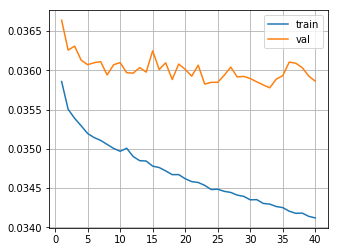

In [25]:
tt.plotHistory(training.history,size=(5,4),save="history_2.png")
tt.toCSV("history_2.csv",training.history)

### SSIM test set validation

In [27]:
def toTensor(x):
    return torch.tensor(x,dtype=torch.float).view(1,-1,96,96).to(device)

In [28]:
ssim = lo.SSIMLoss()
model = Model().to(device)
model.load_state_dict(torch.load("final.pth",map_location=device))
model.eval()

In [ ]:
res = [0.,0.,0.]
for i in range(len(X_test)):
    out = model.predict(toTensor(X_test[i:i+1]),3)
    for j in range(3):
        res[j] += ssim(out[:,j:j+1],toTensor(y_test[i:i+1,j:j+1]))
        
    if i % 8 == 0:
        print('\r'+str(i).zfill(5)+" "+str(res[0]/(i+1)),end='',flush=True)

print("")
for i in range(3):
    res[i] = res[i] / len(X_test)
    print(res[i])
    print("================")